# Making the Pipeline Model

In this script, I'll be using a pre-trained SVM model to perform gender classification on a given image.

First, I import the necessary libraries such as numpy, pandas, matplotlib, and sklearn. I also load the required pickle files and the Haar cascade XML file for face detection.

Then, I define the labels for gender classification and the font for overlay text.

Next, I read the test image using OpenCV and define a pipeline model function. Inside the function, I convert the image to grayscale and detect faces using the Haar cascade classifier. For each detected face, I draw a rectangle around it and perform necessary preprocessing steps. This includes normalizing the cropped face, resizing it to (100,100), flattening the image, subtracting the mean, and applying PCA to obtain the eigen image. I then use the pre-trained SVM model to predict the gender of the face and overlay the prediction and score on the image.

I call the pipeline model function with the test image and display the resulting image. Additionally, I check if the eigen image is not None and if so, I display the inverse of the PCA transformation as an image using matplotlib. If no faces are detected in the image, a corresponding message is printed.

This script allows for gender classification on an image using a pre-trained SVM model and demonstrates the steps involved in the pipeline, from face detection to preprocessing and prediction.

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import pickle
import cv2
import sklearn.svm
import sys
sys.modules['sklearn.svm.classes'] = sklearn.svm

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [61]:
# Load Haar cascade XML file for face detection, trained by OpenCV
haar = cv2.CascadeClassifier(r"W:\MayCooperStation\New Documents\Data Science and ML\FacialRecognition\data\haarcascade_frontalface_default.xml")

In [62]:
# Load pickled preprocessing mean
mean  = pickle.load(open(r'W:\MayCooperStation\New Documents\Data Science and ML\FacialRecognition\data\model\mean_preprocess.pickle','rb'))

# Load SVM model from pickle file
model_svm  = pickle.load(open(r'W:\MayCooperStation\New Documents\Data Science and ML\FacialRecognition\data\model\model_svm.pickle','rb'))

# Load PCA model from pickle file
model_pca  = pickle.load(open(r'W:\MayCooperStation\New Documents\Data Science and ML\FacialRecognition\data\model\pca_50.pickle','rb'))
print('Model loaded sucessfully')

Model loaded sucessfully


In [63]:
# Define labels
gender_pre = ['Male','Female']

# Define font for overlay text
font = cv2.FONT_HERSHEY_SIMPLEX

# Define path to test data
test_data_path = (r"W:\MayCooperStation\New Documents\Data Science and ML\FacialRecognition\data\crop\male_crop\male_8.png")
color = 'bgr'

In [64]:
# Read image using OpenCV
img = cv2.imread(test_data_path)

In [65]:
def pipeline_model(img, color='rgb'):
    # Convert image to grayscale
    if color == 'bgr':
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    else:
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # Detect faces in the image using haar cascade classifier
    faces = haar.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
    for x,y,w,h in faces:
        # Draw rectangle around faces
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        # Crop image to face
        roi = gray[y:y+h,x:x+w]
        # Normalize cropped image
        roi = roi / 255.0
        # Resize cropped image to (100,100)
        if roi.shape[1] > 100:
            roi_resize = cv2.resize(roi,(100,100),cv2.INTER_AREA)
        else:
            roi_resize = cv2.resize(roi,(100,100),cv2.INTER_CUBIC)
        # Flatten resized image
        roi_reshape = roi_resize.reshape(1,10000)
        # Subtract mean
        roi_mean = roi_reshape - mean
        # Apply PCA to get eigen image
        eigen_image = model_pca.transform(roi_mean)
        # Use SVM model to predict gender
        results = model_svm.predict_proba(eigen_image)[0]
        predict = results.argmax() # 0 or 1 
        score = results[predict]
        # Create overlay text with prediction and score
        text = "%s : %0.2f"%(gender_pre[predict],score)
        cv2.putText(img,text,(x,y),font,1,(0,255,0),2)
    return img, eigen_image


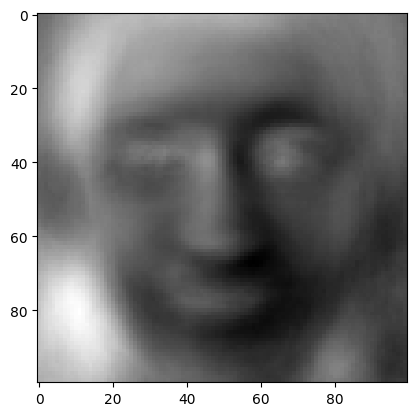

In [66]:
# Call the function and store the results
img, eigen_image = pipeline_model(img)

if eigen_image is not None:
    # Get inverse of PCA transformation
    eig_img = model_pca.inverse_transform(eigen_image)
    plt.imshow(eig_img.reshape((100, 100)), cmap='gray')
else:
    print("No faces detected in the image.")
